#### **1.** Importing libraries

In [ ]:
#-----------------------------------------------------------------------------------------------------------------
#importing libraries
from __future__ import print_function, division
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import argparse
import copy
import datetime
import math
from matplotlib.gridspec import GridSpec
global low, up
from astropy.io import fits as f
from astropy.table import Table as t
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
import scipy.optimize as so
import warnings
warnings.filterwarnings("ignore")
#-----------------------------------------------------------------------------------------------------------------

#### **2.** Importing Data



```
# Date    Day of the Year

   2            275
   3            276
   4            277
  12            285
  13            286
  14            287
```



In [ ]:
# -----------------------------------------------------------------------------------------------------------------
#importing data from my GitHub
url2 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/DATA/output_expdopp_4point_287.txt'
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
dataset2 = pd.read_csv(url2,delimiter = '\t')
print(dataset2.head(5))
dataset2.columns = ["i","timesec","power_total","dopp_firstmoment","second_moment",'exp_dopp']
second_moment = np.array(dataset2.second_moment)	        # Values of second_moment
timesec = np.array(dataset2.timesec)	
zeroth_moment= np.array(dataset2.power_total)  
first_moment= np.array(dataset2.dopp_firstmoment)  
second_moment= np.array(dataset2.second_moment)  
exp_dopp= np.array(dataset2.exp_dopp)            	        # Values of exp_dopp
# -----------------------------------------------------------------------------------------------------------------

   i timesec   power_total   dopp_firstmoment   second_moment   Unnamed: 4  \
0           1      10230.00           0.077761        0.835513    0.747926   
1           1      10230.25           0.073983        0.797783    0.710946   
2           1      10230.50           0.062547        0.888351    1.422530   
3           1      10230.75           0.068714        0.789309    0.704040   
4           2      10231.00           0.072142        0.852026    0.763118   

       exp_dopp  
0 -6.114542e+09  
1 -6.114542e+09  
2 -6.114542e+09  
3 -6.114542e+09  
4 -6.114542e+09  


In [ ]:
# -----------------------------------------------------------------------------------------------------------------
#importing data from my GitHub
url = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/DATA/freqres_2021-287T.txt'
#ET_time(sec) 	 time(sec of day) 	 freq_residual(Hz=exp-theo) 	 exp_dopp 	 theo_dopp 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
dataset = pd.read_csv(url,delimiter = '\t')
print(dataset.head(5))
dataset.columns = ["ET_time(sec)", 	 "time(sec of day)", 	 "freq_residual(Hz=exp-theo)", 	 "exp_dopp" ,	 "theo_dopp" ] 
et = np.array(dataset["ET_time(sec)"])
freq_residual= np.array(dataset["freq_residual(Hz=exp-theo)"])  
exp_dopp= np.array(dataset["exp_dopp"])            	        # Values of exp_dopp
theo_dopp = np.array(dataset["theo_dopp"])	                # Values of theo_dopp
# -----------------------------------------------------------------------------------------------------------------

   ET_time(sec)    time(sec of day)    freq_residual(Hz=exp-theo)   \
0   6.874521e+08            10405.00                  -2892.886093   
1   6.874521e+08            10405.25                  -2892.150709   
2   6.874521e+08            10405.50                  -2889.811024   
3   6.874521e+08            10405.75                  -2890.442937   
4   6.874521e+08            10406.00                  -2890.537751   

    exp_dopp    theo_dopp   
0  18008.4160  20901.30209  
1  18009.1198  20901.27051  
2  18011.4279  20901.23892  
3  18010.7644  20901.20734  
4  18010.6380  20901.17575  


#### **3.** Plotting Doppler

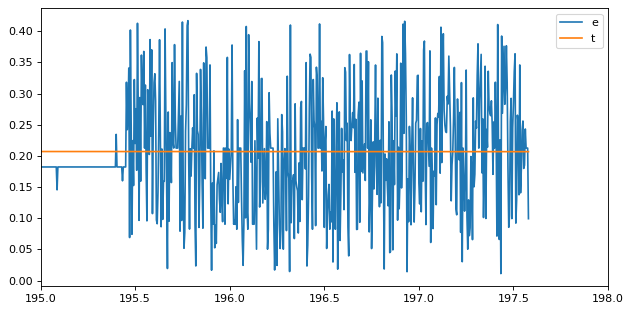

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize = (8,4) , dpi= 80) 

plt.plot(timesec[:-700]/60,exp_dopp/10**5,label="e")
plt.plot(timesec[:-700]/60,theo_dopp/10**5,label="t")
# plt.plot(timesec[:-700]/60,freq_residual/10**5,label="doppler")
plt.legend(loc = 'best')
plt.xlim(195,198)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------------------------------------------

#### **4.** Constants

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
m =9.1*10**(-31)                                 #mass of electron
e = 1.6*10**(-19)                                #charge of electron 
AU = 1.496e+8                                    #1 AU in km
solar_radii = 6.95700e+5                         #1 Solar Radii in km
downconfreq =2310                                #Signal Frequency in MHz
k= 7.705*10**3                                   #Wavenumber per km
l_2= 1.52*AU                                     #1.52AU Distance between Probe and Closest point of Approach to the Sun
alpha = 1.14*10**(-24)                           #Constant from Ho et al.(2002)
L =2.62*AU                                       #2.62AU Distance between Probe and Earth receiving station
ds=L/len(timesec)                                #Path segment on line of sight path between the probe and the receiving station
R = 8.1*solar_radii                              #Closest point of approach in km
epsilon = 8.85* 10**(-12)                        #Epsilon_not
bandwidth =np.mean(exp_dopp)                     #Bandwidth in Hz
# -----------------------------------------------------------------------------------------------------------------
print(len(timesec))
print(timesec[-1])

7200
12029.75


#### **5.** Main code

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
RTEC = (second_moment-(alpha*(downconfreq/1000)**(-1.2)))**(1/1.2)  #freq in ghz

density = RTEC/(7.49*AU)                                       
plasma_frequency = np.sqrt((density*(e**2))/(m*epsilon))            #Chen F. F., 1974

# refractive index equation taken from Hollweg et al. 1970
d_refractive_index =(-1/2)*((plasma_frequency**2/downconfreq**2))*(np.gradient(density)/density)
d_refractive_index = np.nan_to_num(d_refractive_index)

dy = np.gradient(second_moment)

#angular broadening taken from Hollweg et al. 1970
temp = d_refractive_index/dy
temp = temp*ds
angular_broadening = np.sum(temp)

#Solar wind velocity taken from Bird et al. 1982
solar_wind_velocity = (5.77*bandwidth*L)/(angular_broadening*k*l_2)
# -----------------------------------------------------------------------------------------------------------------

#### **6.** Printing Results

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
#Radial Total Electron Content
print("RTEC  =" + str(RTEC)+ '\n')

#Electron Number Density
print("density = " + str(density)+ '\n')

#Plasma Frequency
print("plasma_frequency  =" + str(plasma_frequency)+ '\n')

#Variation in Refractive Index
print("d_refractive_index  =" + str(d_refractive_index)+ '\n')

#Values of Angular Broadening
print("angular_broadening =" + str(angular_broadening)+ '\n')

#Radial Total Electron Content
print("bandwidth  =" + str(bandwidth)+ '\n')

#Final value of Solar Wind Velocity
print("solar_wind_velocity  =" + str(solar_wind_velocity/10**3)+ '\n')  #1483 km/s? km/h?? what?
# -----------------------------------------------------------------------------------------------------------------

RTEC  =[0.78502223 0.75254185 1.34137829 ... 1.23556894 0.77540811 0.78520231]

density = [7.00597435e-10 6.71610143e-10 1.19712048e-09 ... 1.10269034e-09
 6.92017258e-10 7.00758150e-10]

plasma_frequency  =[0.00149232 0.00146112 0.00195073 ... 0.00187221 0.00148315 0.00149249]

d_refractive_index  =[ 8.63393912e-15 -7.39453316e-14  8.10355034e-16 ... -4.39866641e-15
  5.98582678e-14 -2.60349701e-15]

angular_broadening =-9.118186447929841e-05

bandwidth  =18409.19422853846

solar_wind_velocity  =-260.6076649290643



#### **7.** RTEC

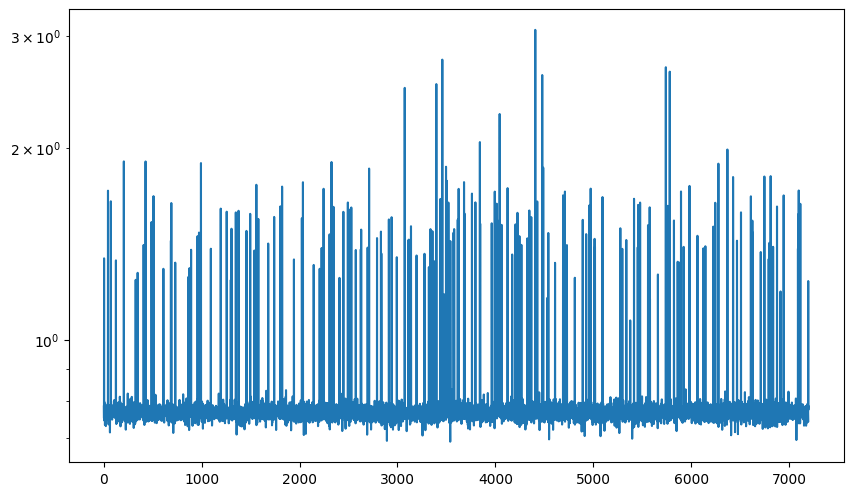

In [ ]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(RTEC)
plt.yscale('log')
plt.show()

[0.78502223 0.75254185 0.74644484 ... 0.74231305 0.77540811 0.78520231]


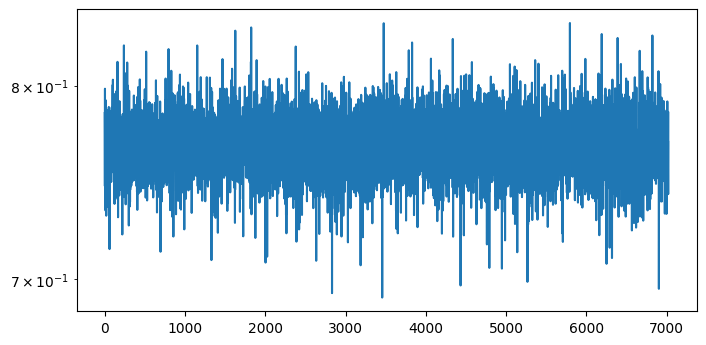

In [ ]:
RTEC = (second_moment-(alpha*(downconfreq/1000)**(-1.2)))**(1/1.2)  #freq in ghz

mean = np.mean(RTEC)
standard_deviation = np.std(RTEC)
distance_from_mean = abs(RTEC - mean)
max_deviations = 2
not_outlier = distance_from_mean < max_deviations * standard_deviation
no_outliers = RTEC[not_outlier]

density_2 = no_outliers/(7.49*10**8) #R in solar radii,RTEC per m3

print(no_outliers)

plt.figure(figsize=(8,4),dpi=100)
plt.plot(no_outliers)
plt.yscale('log')
plt.show()

#### **8.** Number density v/s R

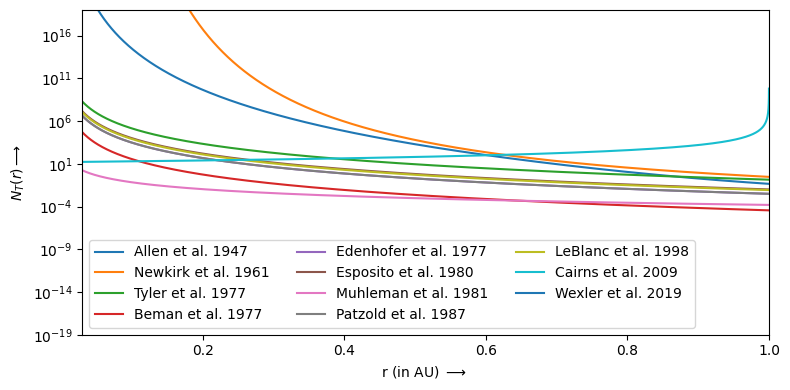

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(8,4),dpi=100)
theta =90 # np.arange(0, 90, 0.0009)
r = np.arange(0.0,5.1,0.00005)

RTEC = (second_moment-(alpha*(downconfreq/1000)**(-1.2)))**(1/1.2)  #freq in ghz

mean = np.mean(RTEC)
standard_deviation = np.std(RTEC)
distance_from_mean = abs(RTEC - mean)
max_deviations = 2
not_outlier = distance_from_mean < max_deviations * standard_deviation
no_outliers = RTEC[not_outlier]


density_2 = no_outliers/(7.49*10**8) 
nom = len(density_2)
density_2 = density_2[3600:]

density_interp = interp.interp1d(np.arange(density_2.size),density_2)
density_stretch = density_interp(np.linspace(0,density_2.size-1,r.size))


A = (((1.55* (10**14)) / r**6)  + (3.44*(10**11)))* (((np.cos(theta*np.pi))**2 * (1/64)*(np.sin(theta))**2)**(-1/2))   # Tyler et al. 1977
B = (((2.39* (10**14)) / r**6)  + (1.67*(10**12)/ (r**(2.3))))*(10**(-0.9*theta*np.pi/90))                             # Beman et al. 1977
C = (1.58* 10**17)/((r-1)**2)                                                                                          # Cairns et al. 2009
D = 14.2*(10**10)*(10**(4.32/r))                                                                                       # Newkirk et al. 1961
E = (10**14)*((2.99/(r**16))+(1.55/(r**6)))                                                                            # Allen-Baubach et al. 1947
F = (10**12)*((65/(r**5.94))+(0.768/((r-1)**2.25)))                                                                    # Wexler et al. 2019
G = ((8* 10**13)/(r**6))+((4.1* 10**12)/(r**4))+((3.3* 10**11)/(r**2))                                                 # LeBlanc et al. 1998 
H = (10**12)*((30/r**6)+(1/r**2.2))                                             # HELIOS 2                             # Patzold et al. 1987
I = (10**12)*((100/r**6)+(0.5/r**2.1))                                          # HELIOS 2                             # Esposito et al. 1980
J = (10**12)*((1.32/r**2.7)+(0.23/r**2.04))                                     # VIKING                               # Muhleman et al 1981
K = (10**12)*((30/r**6)+(1/r**2.2))                                             #1976 HELIOS DATA                      # Edenhofer et al. 1977

plt.plot(r,E/10**16, label = "Allen et al. 1947")
plt.plot(r,D/10**16, label = "Newkirk et al. 1961")
plt.plot(r,A/10**16, label ="Tyler et al. 1977")
plt.plot(r,B/10**16, label = "Beman et al. 1977")
plt.plot(r,K/10**16, label = "Edenhofer et al. 1977")
plt.plot(r,I/10**16, label = "Esposito et al. 1980")
plt.plot(r,J/10**16, label = "Muhleman et al. 1981")
plt.plot(r,H/10**16, label = "Patzold et al. 1987")
plt.plot(r,G/10**16, label = "LeBlanc et al. 1998")
plt.plot(r,C/10**16, label = "Cairns et al. 2009")
plt.plot(r,F/10**16, label = "Wexler et al. 2019")

# plt.plot(r,density_stretch*10**10,'k-',label="MOM 2021")
plt.yscale('log')
plt.ylim(10**(-19),10**19)
plt.legend(ncol =3,loc='best')
plt.xlim(0.03,1)
plt.ylabel("$N_T(r) \longrightarrow$")
plt.xlabel("r (in AU) $\longrightarrow$ ")
plt.tight_layout()
plt.show()


#### **9.** Solarwind velocity at L1 using omniweb

In [ ]:
#OMNIWeb Plus Browser Results

#importing data from my GitHub
# url3 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/omniweb_ace_275.txt' #Data for 2nd October 2021
# url3 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/omniweb_ace_276.txt' #Data for 3rd October 2021
# url3 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/omniweb_ace_277.txt' #Data for 4th October 2021
# url3 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/omniweb_ace_285.txt' #Data for 12th October 2021
# url3 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/omniweb_ace_286.txt' #Data for 13th October 2021
url3 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/OMNI/omniweb_ace_287.txt' #Data for 14th October 2021
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
dataset3 = pd.read_csv(url3,delimiter = ' ')
print(dataset3.head(5))
dataset3.columns = ["YYYY",'DOY','HR','MN','V']
V= dataset3["V"]         	        # Values of exp_dopp
DOY = dataset3["DOY"]

mean_V= np.mean(V)
standard_deviation_V= np.std(V)
distance_from_mean_V= abs(V - mean)
max_deviations_V = 2
not_outlier_V = distance_from_mean_V < max_deviations_V * standard_deviation_V
no_outliers_V = V[not_outlier_V]

# print(no_outliers_V)
# -----------------------------------------------------------------------------------------------------------------

   YYYY  DOY  HR  MN      V
0  2021  287   0   0  383.2
1  2021  287   0   5  382.9
2  2021  287   0  10  392.2
3  2021  287   0  15  405.9
4  2021  287   0  20  392.0


#### **10.** Data v/s ACE (Omniweb)

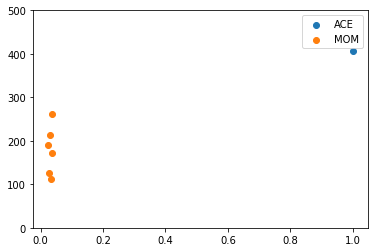

In [ ]:
DATE = (2,3,4,12,13,14)
rad_RS = (8.1,6.92,5.77,5.24,6.33,7.49)
rad_AU = (0.0376682486631016,0.03218077540106952,0.02683281417112299,0.024368101604278075,0.029437038770053475,0.03483150401069519)
RAD = (215,215,215,215,215,215)

ACE = (429.03935018050544,396.5900355871886,351.1381147540984,448.0744604316547,423.5188811188811,384.7982332155477)
DATA = (172.2372178386981,112.8371379956578,126.64897552013602,189.5309413834875,212.84972355776773,260.60766492906432)
plt.scatter(np.mean(RAD)/215,np.mean(ACE),label="ACE")
plt.scatter(rad_AU,DATA,label="MOM")
plt.legend()
plt.ylim(0,500)
plt.show()

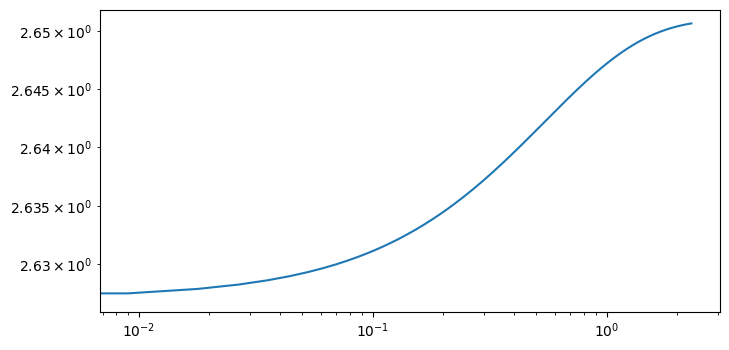

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.optimize as so

plt.figure(figsize=(8,4),dpi=100)
x = np.linspace(1,10,1000)
y = (172.2372178386981,112.8371379956578,126.64897552013602,189.5309413834875,212.84972355776773,260.60766492906432)

a_1 = 2.651
a_2 = 0
a_3 = -0.0239
a_4 = -1.836
X = np.log(x)
Y = np.log(y)

Y = a_1 + a_2*X + a_3*(np.exp(a_4*X))
# plt.scatter(np.log(np.mean(RAD)/215),np.log(np.mean(ACE)),label="ACE")
# plt.scatter(np.log(rad*(solar_radii/AU)),np.log(DATA),label="MOM")
plt.plot(X,Y)
plt.xscale('log')
plt.yscale('log')
plt.show()